## 1. Imports and Configuration

In [1]:
import sys
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Add root directory to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import NWS Stations synchronous adapter
from scripts.api.services.nws_stations.nws_stations_sync_adapter import NWSStationsSyncAdapter

# Get API information
from scripts.api.services.nws_stations.nws_stations_client import NWSStationsClient

# Configure logging
logger.remove()
logger.add(sys.stdout, level="INFO")

# Configure plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports completed successfully")

Imports completed successfully


## 2. Initialize NWS Stations Client

In [2]:
# Create synchronous adapter (no cache for demo)
nws_adapter = NWSStationsSyncAdapter()

info = NWSStationsClient.get_data_availability_info()
print("\nNWS Stations API Information:")
for key, value in info.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            print(f"    {k}: {v}")
    else:
        print(f"  {key}: {value}")

2025-11-29 04:59:39.827 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:__init__:122 - NWSStationsSyncAdapter initialized (filter_delayed=False)

NWS Stations API Information:
  source: NWS Stations (NOAA)
  coverage: USA (including Alaska, Hawaii, territories)
  stations: ~1800 active stations
  data_type: Hourly observations
  bbox:
    lon_min: -180.0
    lon_max: -66.0
    lat_min: 18.0
    lat_max: 71.5
  temporal_resolution: Hourly
  update_frequency: Real-time (continuous)
  typical_delay: Up to 20 minutes (MADIS processing)
  license: US Government Public Domain
  attribution: National Weather Service / NOAA
  api_docs: https://www.weather.gov/documentation/services-web-api
  known_issues:
    observation_delay: Up to 20 minutes normal (MADIS)
    null_temps: Max/min temps may be null outside CST timezone
    station_variability: Not all stations report all parameters

NWS Stations API Information:
  source: NWS Stations (NOAA)
  coverage: USA (includin

## 3. Download Observational Data - Fairplay, Park, Colorado

Let's download observational data from weather stations near **Fairplay, Park, Colorado**.

**Coordinates**: 39.2241°N, -106.0940°W  
**Period**: Last 5 days

In [3]:
import nest_asyncio
nest_asyncio.apply()

# Download observational data
print("\nDownloading observational data from NWS Stations...\n")
print("Searching for nearby stations and collecting observations...\n")

# Define location: Fairplay, Park, Colorado
lat = 39.2241
lon = -106.0940
location_name = "Fairplay, Park, Colorado"

# Define desired period (can be 1, 3, 5, 6 or 7 days)
start_date = datetime.now() - timedelta(days=6)
end_date = datetime.now()

# Define period: last 6 days
print(f"Downloading observational data for the last {(end_date - start_date).days} days for {location_name}...")

data = nws_adapter.get_daily_data_sync(
    lat=lat,
    lon=lon,
    start_date=start_date,   
    end_date=end_date  
)

print(f"\nData downloaded: {len(data)} daily records")
for d in data:
    print(f"  {d.date.date()}: T={d.temp_mean:.1f}°C, RH={d.humidity:.0f}%, V={d.wind_speed:.1f} m/s")



Searching for nearby stations and collecting observations...

2025-11-29 04:59:40.176 | SUCCESS  | scripts.api.services.nws_stations.nws_stations_client:__init__:115 - NWSStationsClient initialized
2025-11-29 04:59:40.177 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:_async_get_daily_data:202 - Searching for nearest active NWS station: (39.2241, -106.094)
2025-11-29 04:59:40.177 | INFO     | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:150 - Searching for active station near (39.2241, -106.0940)
2025-11-29 04:59:40.176 | SUCCESS  | scripts.api.services.nws_stations.nws_stations_client:__init__:115 - NWSStationsClient initialized
2025-11-29 04:59:40.177 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:_async_get_daily_data:202 - Searching for nearest active NWS station: (39.2241, -106.094)
2025-11-29 04:59:40.177 | INFO     | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active

## 4. Convert to DataFrame and Explore

In [4]:
# Convert to DataFrame
df = pd.DataFrame([
    {
        'date': record.date,
        'temp_max': record.temp_max,
        'temp_min': record.temp_min,
        'temp_mean': record.temp_mean,
        'humidity': record.humidity,
        'wind_speed': record.wind_speed,
    }
    for record in data
])

# Display first rows
print("\nObservational Data (daily aggregates):")
display(df.head())

# Check data completeness
print("\nData Completeness:")
completeness = df.notna().sum() / len(df) * 100
for col, pct in completeness.items():
    if col != 'date':
        print(f"  {col}: {pct:.1f}%")


Observational Data (daily aggregates):


,date,temp_max,temp_min,temp_mean,humidity,wind_speed
0,2025-11-27,6.0,-8.0,0.71,54.86,2.30
1,2025-11-28,6.0,-3.0,0.61,49.61,2.72
2,2025-11-29,1.0,-4.4,-1.17,56.85,4.17



Data Completeness:
  temp_max: 100.0%
  temp_min: 100.0%
  temp_mean: 100.0%
  humidity: 100.0%
  wind_speed: 100.0%


In [5]:
# Descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,date,temp_max,temp_min,temp_mean,humidity,wind_speed
count,3,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2025-11-28 00:00:00,4.333333,-5.133333,0.050000,53.773333,3.063333
min,2025-11-27 00:00:00,1.000000,-8.000000,-1.170000,49.610000,2.300000
25%,2025-11-27 12:00:00,3.500000,-6.200000,-0.280000,52.235000,2.510000
50%,2025-11-28 00:00:00,6.000000,-4.400000,0.610000,54.860000,2.720000
75%,2025-11-28 12:00:00,6.000000,-3.700000,0.660000,55.855000,3.445000
max,2025-11-29 00:00:00,6.000000,-3.000000,0.710000,56.850000,4.170000
std,NaN,2.886751,2.579406,1.057733,3.740325,0.981139


## 5. Visualizations

### 5.1 Observed Temperatures

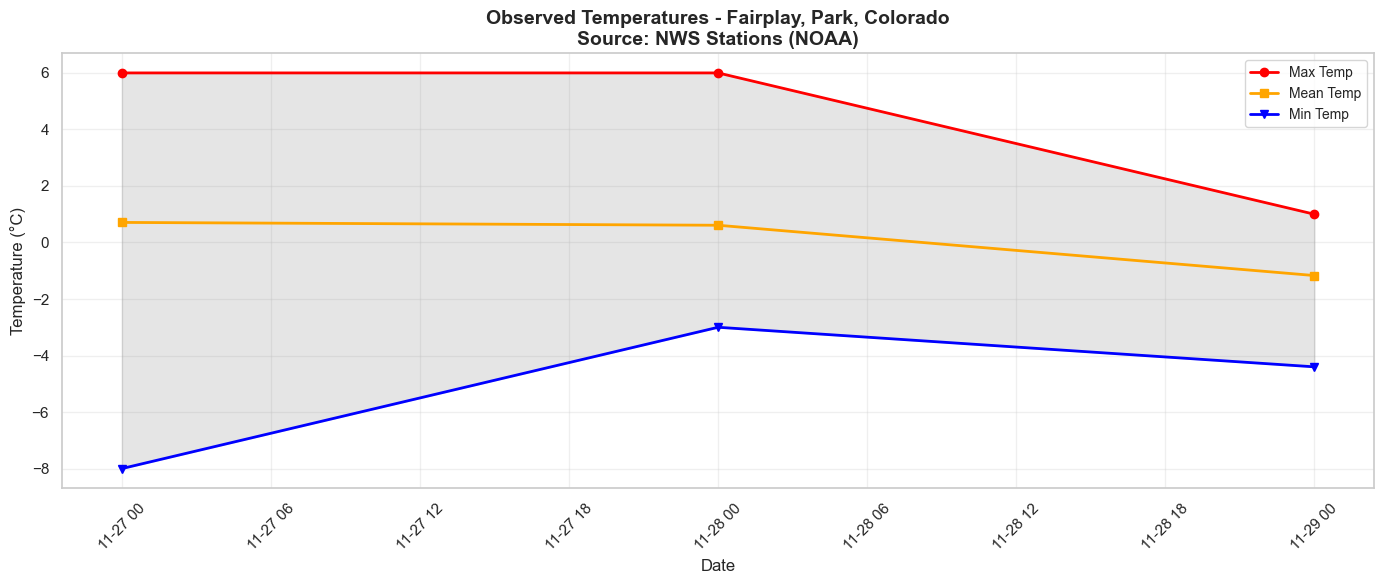

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['date'], df['temp_max'], label='Max Temp', color='red', linewidth=2, marker='o')
ax.plot(df['date'], df['temp_mean'], label='Mean Temp', color='orange', linewidth=2, marker='s')
ax.plot(df['date'], df['temp_min'], label='Min Temp', color='blue', linewidth=2, marker='v')

ax.fill_between(df['date'], df['temp_min'], df['temp_max'], alpha=0.2, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(f'Observed Temperatures - {location_name}\nSource: NWS Stations (NOAA)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.2 Observed Temperature Max and Humidity

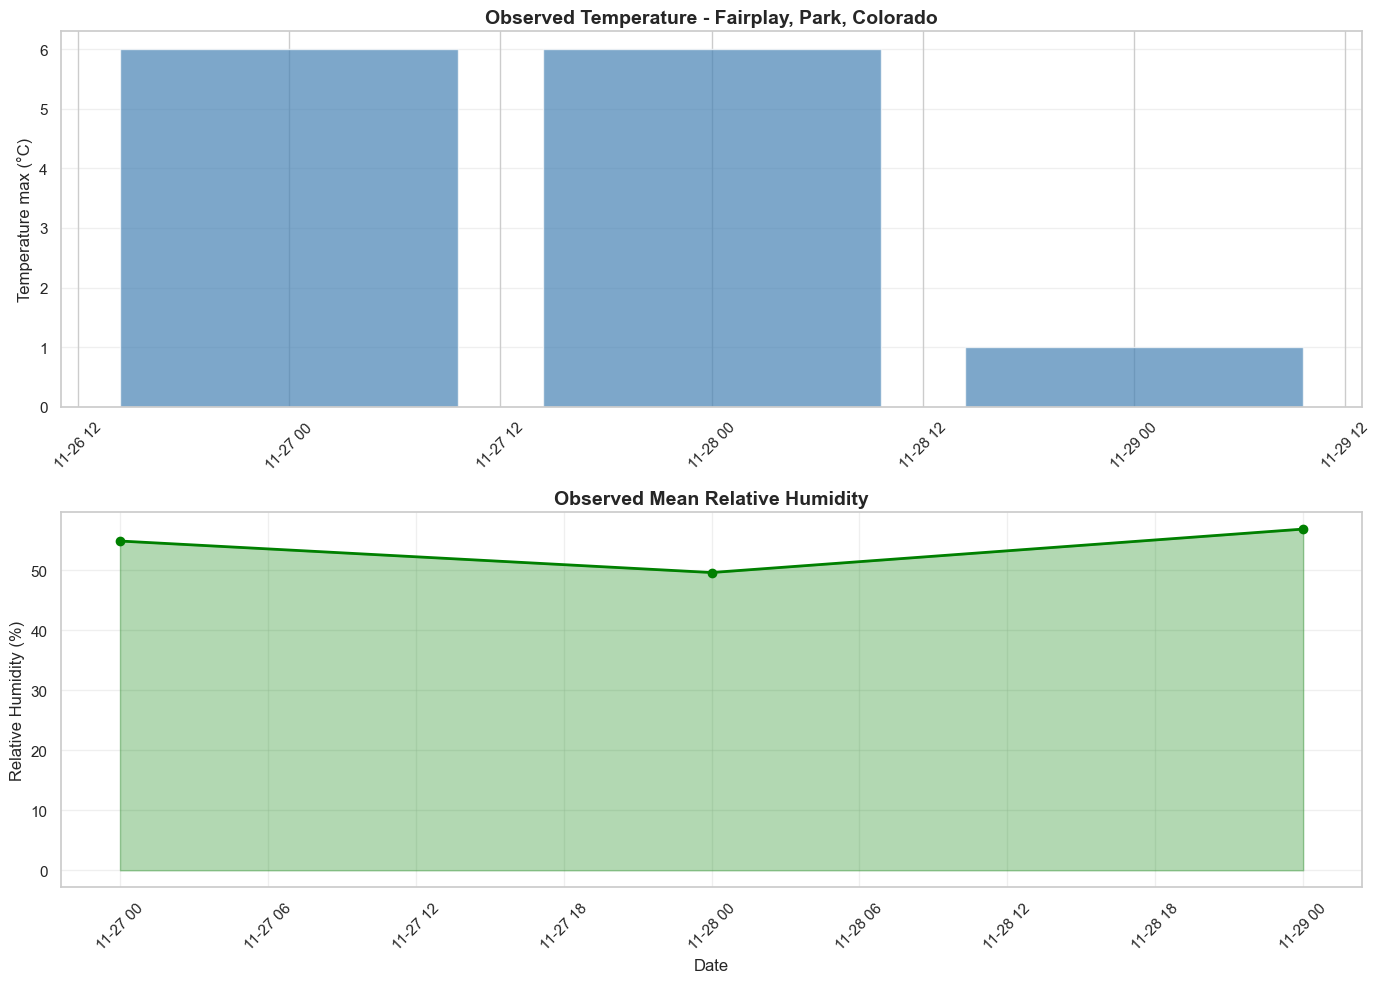

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Temperature Max
ax1.bar(df['date'], df['temp_max'], color='steelblue', alpha=0.7)
ax1.set_ylabel('Temperature max (°C)', fontsize=12)
ax1.set_title(f'Observed Temperature - {location_name}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Relative Humidity
ax2.plot(df['date'], df['humidity'], color='green', linewidth=2, marker='o')
ax2.fill_between(df['date'], df['humidity'], alpha=0.3, color='green')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Relative Humidity (%)', fontsize=12)
ax2.set_title('Observed Mean Relative Humidity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### 5.3 Observed Wind Speed

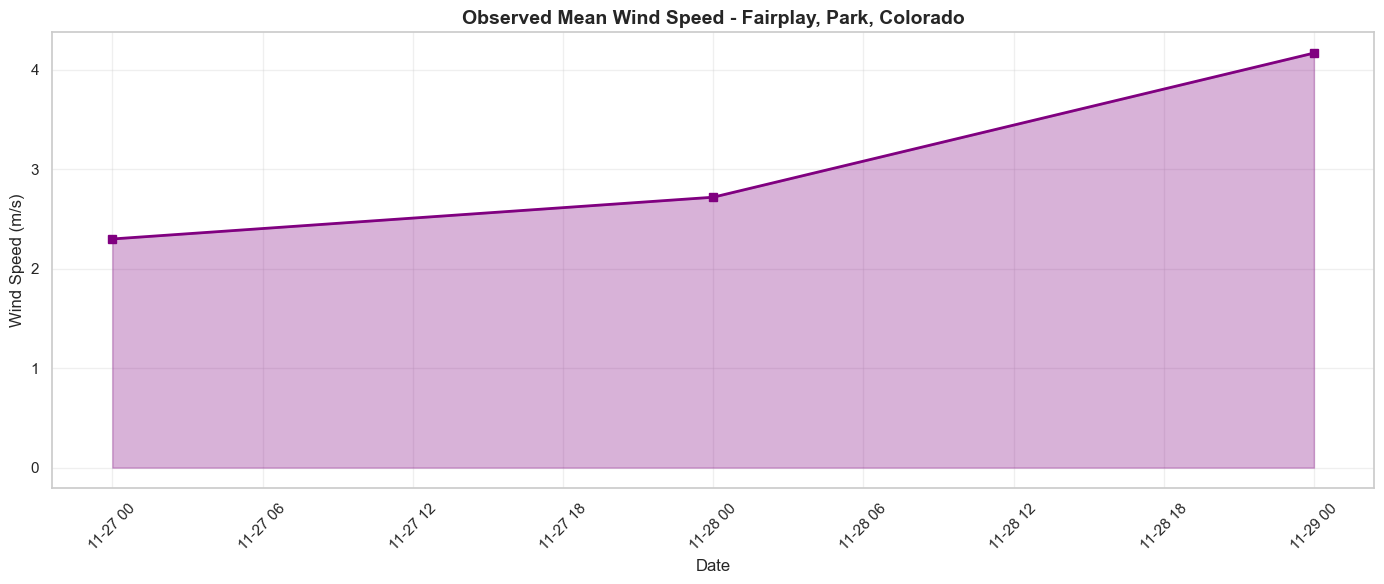

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['date'], df['wind_speed'], color='purple', linewidth=2, marker='s')
ax.fill_between(df['date'], df['wind_speed'], alpha=0.3, color='purple')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Wind Speed (m/s)', fontsize=12)
ax.set_title(f'Observed Mean Wind Speed - {location_name}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Example 2: Miami, FL

In [9]:
# Define location: Miami, FL
lat_miami = 25.7617
lon_miami = -80.1918
location_miami = "Miami, FL"

print(f"Location: {location_miami}")
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Coordinates: {lat_miami:.4f}°, {lon_miami:.4f}°")

# Download data
print("\nDownloading observational data from NWS Stations...\n")

miami_data = nws_adapter.get_daily_data_sync(
    lat=lat_miami,
    lon=lon_miami,
    start_date=start_date,
    end_date=end_date
)

print(f"\nData downloaded: {len(miami_data)} records")

Location: Miami, FL
Period: 2025-11-23 to 2025-11-29
Coordinates: 25.7617°, -80.1918°


2025-11-29 04:59:45.884 | SUCCESS  | scripts.api.services.nws_stations.nws_stations_client:__init__:115 - NWSStationsClient initialized
2025-11-29 04:59:45.885 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:_async_get_daily_data:202 - Searching for nearest active NWS station: (25.7617, -80.1918)
2025-11-29 04:59:45.885 | INFO     | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:150 - Searching for active station near (25.7617, -80.1918)
2025-11-29 04:59:45.884 | SUCCESS  | scripts.api.services.nws_stations.nws_stations_client:__init__:115 - NWSStationsClient initialized
2025-11-29 04:59:45.885 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:_async_get_daily_data:202 - Searching for nearest active NWS station: (25.7617, -80.1918)
2025-11-29 04:59:45.885 | INFO     | scripts.api.services.nws_stations.nws_stations_cli

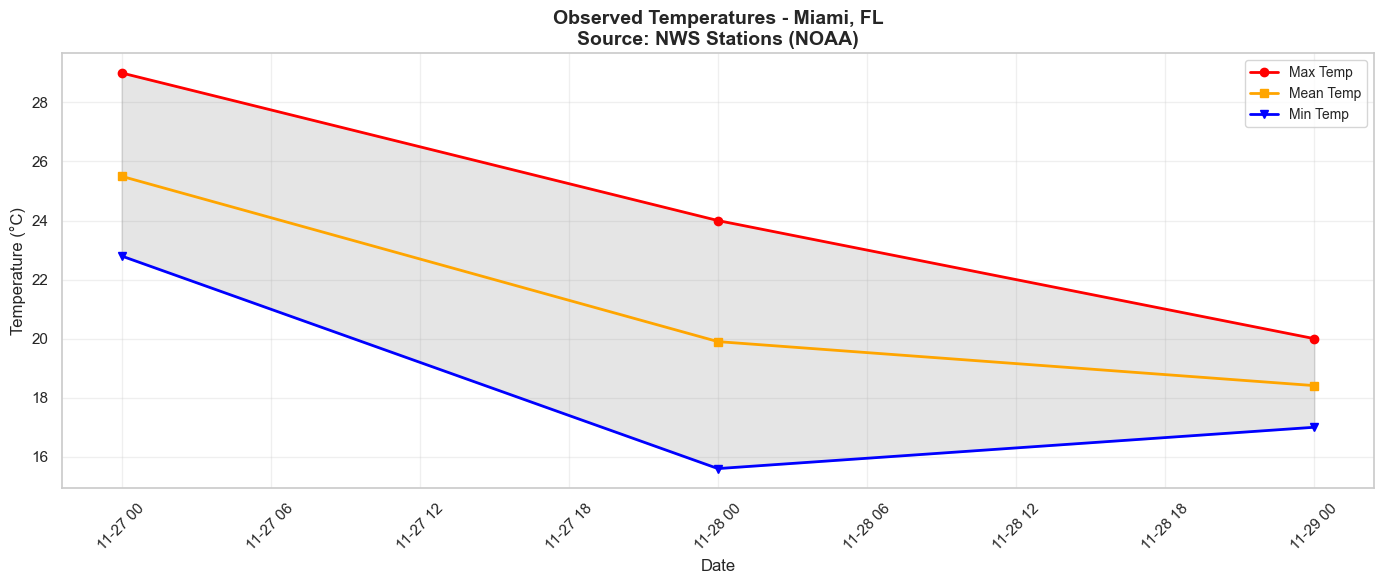

In [10]:
# Convert to DataFrame
df_miami = pd.DataFrame([
    {
        'date': record.date,
        'temp_max': record.temp_max,
        'temp_min': record.temp_min,
        'temp_mean': record.temp_mean,
        'humidity': record.humidity,
        'wind_speed': record.wind_speed,
    }
    for record in miami_data
])

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_miami['date'], df_miami['temp_max'], label='Max Temp', color='red', linewidth=2, marker='o')
ax.plot(df_miami['date'], df_miami['temp_mean'], label='Mean Temp', color='orange', linewidth=2, marker='s')
ax.plot(df_miami['date'], df_miami['temp_min'], label='Min Temp', color='blue', linewidth=2, marker='v')
ax.fill_between(df_miami['date'], df_miami['temp_min'], df_miami['temp_max'], alpha=0.2, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(f'Observed Temperatures - {location_miami}\nSource: NWS Stations (NOAA)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Compare Fairplay vs Miami

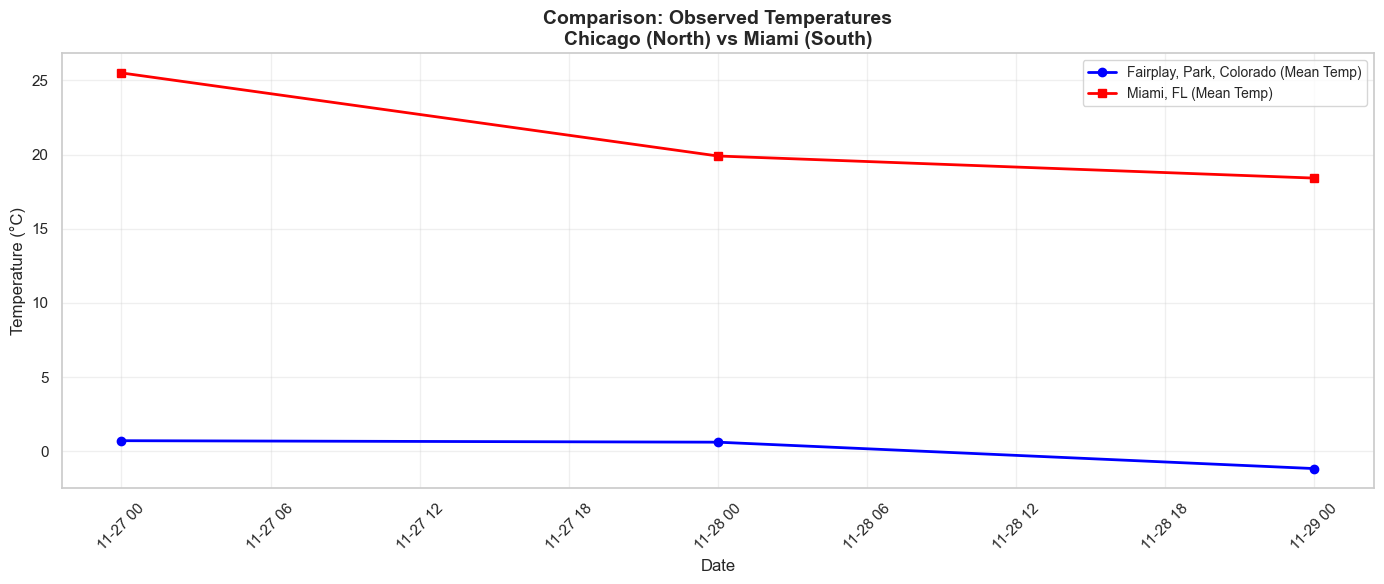


Comparative Statistics (Mean Temperature):
  Fairplay, Park, Colorado: 0.05°C (±1.06°C)
  Miami, FL: 21.27°C (±3.74°C)


In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

# Chicago
ax.plot(df['date'], df['temp_mean'], label=f'{location_name} (Mean Temp)', 
        color='blue', linewidth=2, marker='o')

# Miami
ax.plot(df_miami['date'], df_miami['temp_mean'], label=f'{location_miami} (Mean Temp)', 
        color='red', linewidth=2, marker='s')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title('Comparison: Observed Temperatures\nChicago (North) vs Miami (South)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparative statistics
print("\nComparative Statistics (Mean Temperature):")
print(f"  {location_name}: {df['temp_mean'].mean():.2f}°C (±{df['temp_mean'].std():.2f}°C)")
print(f"  {location_miami}: {df_miami['temp_mean'].mean():.2f}°C (±{df_miami['temp_mean'].std():.2f}°C)")

## 8. Health Check

In [12]:
# Check API availability
is_healthy = nws_adapter.health_check_sync()

if is_healthy:
    print("NWS Stations API is working correctly")
else:
    print("NWS Stations API is not accessible")

2025-11-29 04:59:52.303 | SUCCESS  | scripts.api.services.nws_stations.nws_stations_client:__init__:115 - NWSStationsClient initialized
2025-11-29 04:59:52.308 | INFO     | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:150 - Searching for active station near (40.7128, -74.0060)
2025-11-29 04:59:52.308 | INFO     | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:150 - Searching for active station near (40.7128, -74.0060)
2025-11-29 04:59:55.309 | WARNING  | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:226 - No active station - using fallback: KNYC
2025-11-29 04:59:55.309 | INFO     | scripts.api.services.nws_stations.nws_stations_sync_adapter:_async_health_check:341 - NWS health check: OK
NWS Stations API is working correctly
2025-11-29 04:59:55.309 | WARNING  | scripts.api.services.nws_stations.nws_stations_client:find_nearest_active_station:226 - No active station - using fallbac

## 9. Save Data

In [13]:
# Save Chicago data
output_fairplay = project_root / "data" / "csv" / "nws_stations_fairplay_demo.csv"
output_fairplay.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_fairplay, index=False)
print(f"\nFairplay data saved to: {output_fairplay}")

# Save Miami data
output_miami = project_root / "data" / "csv" / "nws_stations_miami_demo.csv"
df_miami.to_csv(output_miami, index=False)
print(f"Miami data saved to: {output_miami}")


Fairplay data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\nws_stations_fairplay_demo.csv
Miami data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\nws_stations_miami_demo.csv


---

## References

**NWS Stations (National Weather Service - NOAA)**
- Website: https://www.weather.gov/
- API Documentation: https://www.weather.gov/documentation/services-web-api
- Citation: National Weather Service, National Oceanic and Atmospheric Administration (NOAA)

**License**: US Government Public Domain

**Station Network**: ~1,800 NOAA weather stations in the USA

**Known Issues**:
- Delayed observations (>20min MADIS delay) - optionally filtered
- Null values in temperatures (max/min outside CST) - skipped

---